In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install netCDF4
!pip install cartopy

In [ ]:
import xarray as xr
import pandas as pd

# File path
file_path = r"/content/drive/MyDrive/(OMI vs IAGOS)Lab Internship/Data/omi_l2_v2+soft+cmc_2022m0302_v0401_BY2_S05N65.nc"

# Open the dataset
ds = xr.open_dataset(file_path)

# Set display options for xarray and pandas to show more rows and larger width
xr.set_options(display_style='text', display_max_rows=1000, display_expand_data_vars=True)

# If the dataset contains many metadata entries, you may also need to adjust pandas settings here
pd.set_option('display.max_colwidth', None)  # Print full column width
pd.set_option('display.max_rows', 1000)      # Display all rows

# Print detailed information about the dataset
print("Dataset detailed information:")
print(ds)

# Print the dataset's attribute information
print("Attributes:")
for attr, value in ds.attrs.items():
    print(f"{attr}: {value}")

# Print the units of each variable
print("\nVariables and their units:")
for var_name, var_data in ds.data_vars.items():
    unit = var_data.attrs.get('units', 'No unit attribute')
    print(f"{var_name}: {unit}")

# Reload the dataset (optional, since it's already loaded above)
ds = xr.open_dataset(file_path)

# Latitude and longitude coordinates for ICN Airport
icn_lat = 37.4563  # Latitude
icn_lon = 126.4516  # Longitude

# Extract latitude and longitude data
lats = ds['lat']  # Latitude array
lons = ds['lon']  # Longitude array

# Find the index of the pixel closest to ICN
lat_diff = abs(lats - icn_lat)
lon_diff = abs(lons - icn_lon)
distance = lat_diff + lon_diff  # Simple distance metric; can be replaced with a more accurate spherical distance formula
closest_pixel_index = distance.argmin()

# Extract layer boundary height information (in km) for the nearest pixel
layer_boundary_heights = ds['zs']    # Shape: (nlp1, mpix)
ozone_layer_data = ds['ozprof']      # Shape: (nl, mpix)

# Select the pixel closest to ICN
layer_heights_icn = layer_boundary_heights.isel(mpix=closest_pixel_index)  # Extract layer boundary heights for the nearest pixel

# Print all layer boundary heights for the ICN pixel, converting units to meters (m)
print("Layer Boundary Heights for ICN (in m):")
for i, height in enumerate(layer_heights_icn.values):
    height_m = height * 1000  # Convert height from km to m
    print(f"Layer boundary {i+1}: {height_m:.2f} m")

# Calculate the actual center height of each layer (layer center height = average of adjacent layer boundary heights)
nlayer_heights_icn = 0.5 * (layer_heights_icn[:-1] + layer_heights_icn[1:])

print("\nCenter Heights for each Layer (in m):")
for i, center_height in enumerate(nlayer_heights_icn.values):
    center_height_m = center_height * 1000  # Convert height from km to m
    print(f"Layer {i+1} center height: {center_height_m:.2f} m")


In [ ]:
import xarray as xr

# File path
file_path = fr"/content/drive/MyDrive/(OMI vs IAGOS)Lab Internship/Data/omi_l2_v2+soft+cmc_2022m0302_v0401_BY2_S05N65.nc"

# Load the dataset
ds = xr.open_dataset(file_path)

# Latitude and longitude coordinates of ICN Airport
icn_lat = 37.4563  # Latitude
icn_lon = 126.4516  # Longitude

# Extract latitude and longitude data
lats = ds['lat']  # Latitude array
lons = ds['lon']  # Longitude array

# Find the index of the pixel closest to ICN
lat_diff = abs(lats - icn_lat)
lon_diff = abs(lons - icn_lon)
distance = lat_diff + lon_diff  # Simple distance metric; can be replaced with a more accurate spherical distance formula
closest_pixel_index = distance.argmin()

# Extract the layer boundary height information for the closest pixel (units in km)
layer_boundary_heights = ds['zs']  # Shape is (nlp1, mpix)
ozone_layer_data = ds['ozprof']  # Shape is (nl, mpix)

# Select the pixel closest to ICN
layer_heights_icn = layer_boundary_heights.isel(mpix=closest_pixel_index)  # Extract layer boundary heights for the closest pixel

# Print all layer boundary heights for the ICN pixel, converted to meters (m)
print("Layer Boundary Heights for ICN (in m):")
for i, height in enumerate(layer_heights_icn.values):
    height_m = height * 1000  # Convert height from km to m
    print(f"Layer boundary {i+1}: {height_m:.2f} m")

# Calculate the actual layer center heights (layer center height = average of adjacent layer boundary heights)
nlayer_heights_icn = 0.5 * (layer_heights_icn[:-1] + layer_heights_icn[1:])

print("\nCenter Heights for each Layer (in m):")
for i, center_height in enumerate(nlayer_heights_icn.values):
    center_height_m = center_height * 1000  # Convert height from km to m
    print(f"Layer {i+1} center height: {center_height_m:.2f} m")


/usr/local/lib/python3.10/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'nl'} appear more than once in dims=('nl', 'nl', 'mpix'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)


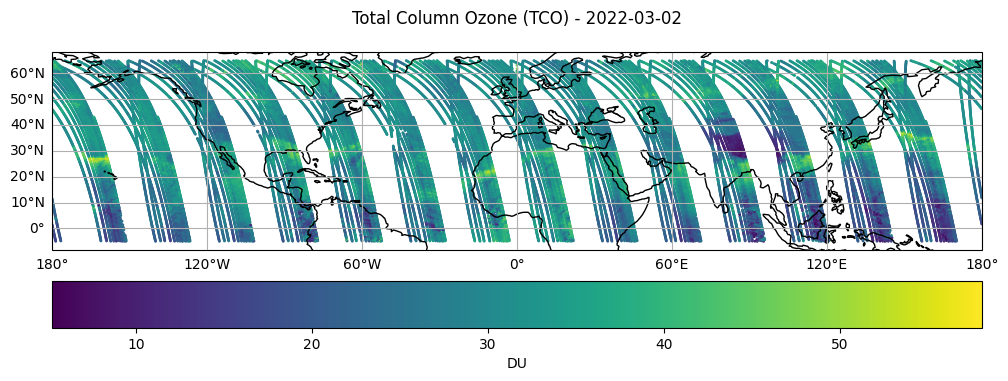

/usr/local/lib/python3.10/dist-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'nl'} appear more than once in dims=('nl', 'nl', 'mpix'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)


Selected nearest coordinates: Latitude = 37.38153076171875, Longitude = 126.8258056640625


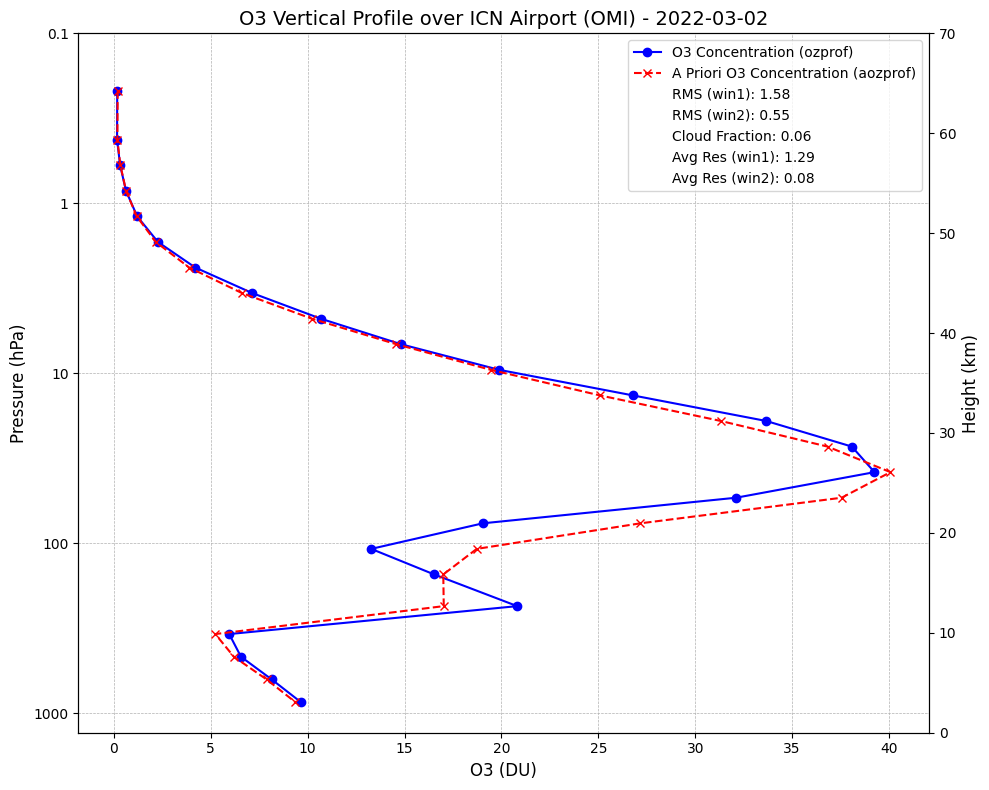

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import re  # For regular expressions to extract dates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D  # For custom legend elements

# File path
file_path = r"/content/drive/MyDrive/(OMI vs IAGOS)Lab Internship/Data/omi_l2_v2+soft+cmc_2022m0302_v0401_BY2_S05N65.nc"

# Extract date from the file name
file_name = file_path.split("\\")[-1]  # Extract the file name
date_match = re.search(r'(\d{4})m(\d{2})(\d{2})', file_name)  # Regex to match the date

# If a match is found, extract and format the date
if date_match:
    year, month, day = date_match.groups()
    formatted_date = f"{year}-{month}-{day}"  # Format as YYYY-MM-DD
else:
    formatted_date = "Unknown Date"  # If no date is found

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

# Extract variables tco (Total Column Ozone), lat, and lon
tco = ds['tco']
lat = ds['lat']
lon = ds['lon']

# Plot the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use lat and lon as coordinates to plot tco
tco_plot = ax.scatter(lon, lat, c=tco, cmap='viridis', s=1, transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()

# Display latitude and longitude gridlines with automatic labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False  # Disable top longitude labels
gl.right_labels = False  # Disable right latitude labels

# Set the title, including the extracted date
plt.title(f'Total Column Ozone (TCO) - {formatted_date}', pad=20)

# Add a color bar at the bottom of the plot
cbar = plt.colorbar(tco_plot, orientation='horizontal', pad=0.05)
cbar.set_label('DU')  # DU stands for Dobson Units

plt.show()

# Extract date from the file name again (this section seems duplicated; ensure it's intentional)
file_name = file_path.split("\\")[-1]  # Extract the file name
date_match = re.search(r'(\d{4})m(\d{2})(\d{2})', file_name)  # Regex to match the date

# If a match is found, format the date
if date_match:
    year, month, day = date_match.groups()
    formatted_date = f"{year}-{month}-{day}"  # Format as YYYY-MM-DD
else:
    formatted_date = "Unknown Date"  # If no date is found

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

# Extract variables
ozprof = ds['ozprof']        # Vertical ozone profile (nl, mpix)
aozprof = ds['aozprof']      # A priori ozone profile (nl, mpix)
ps = ds['ps']                # Pressure boundaries (nlp1, mpix)
zs = ds['zs']                # Height boundaries (km)
rms = ds['rms']              # Root Mean Square Error (win, mpix)
cfrac = ds['cfrac']          # Cloud fraction (mpix)
avgres = ds['avgres']        # Average residual (win, mpix)

# Latitude and longitude for Incheon International Airport (ICN)
icn_lat = 37.46
icn_lon = 126.44

# Extract latitude and longitude values
lat = ds['lat'].values
lon = ds['lon'].values

# Find the data point closest to ICN
distance = np.sqrt((lat - icn_lat)**2 + (lon - icn_lon)**2)
nearest_index = distance.argmin()

# Get the nearest latitude and longitude
nearest_lat = lat[nearest_index]
nearest_lon = lon[nearest_index]

# Print the selected nearest coordinates
print(f"Selected nearest coordinates: Latitude = {nearest_lat}, Longitude = {nearest_lon}")

# Get the vertical ozone profile and pressure/height information for the ICN point
icn_ozprof = ozprof[:, nearest_index].values        # Ozone concentration per layer (24 layers)
icn_aozprof = aozprof[:, nearest_index].values      # A priori ozone concentration per layer (24 layers)
icn_ps = ps[:, nearest_index].values                # Pressure boundaries (25 boundaries)
icn_zs = zs[:, nearest_index].values                # Height boundaries (25 boundaries)
icn_rms = rms[:, nearest_index].values              # RMS error data (win, )
icn_cfrac = cfrac[nearest_index].values             # Cloud fraction
icn_avgres = avgres[:, nearest_index].values         # Average residual data (win, )

# Calculate the average pressure for each layer by averaging the pressure boundaries
lower_boundary_ps = icn_ps[:-1]  # Lower boundary pressure (24 values)
upper_boundary_ps = icn_ps[1:]   # Upper boundary pressure (24 values)
average_ps_hpa = (lower_boundary_ps + upper_boundary_ps) / 2  # Average pressure per layer (hPa)

# Calculate the average height for each layer by averaging the height boundaries
lower_boundary_zs = icn_zs[:-1]  # Lower boundary height (24 values)
upper_boundary_zs = icn_zs[1:]   # Upper boundary height (24 values)
average_zs_km = (lower_boundary_zs + upper_boundary_zs) / 2  # Average height per layer (km)

# Take the logarithm (base 10) of the average pressure
log_average_ps = np.log10(average_ps_hpa)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 8))  # Increase figure size for better readability

# Plot O3 profile (ozprof)
line1, = ax1.plot(icn_ozprof, log_average_ps, marker='o', linestyle='-', color='b', label='O3 Concentration (ozprof)')

# Plot A priori O3 profile (aozprof)
line2, = ax1.plot(icn_aozprof, log_average_ps, marker='x', linestyle='--', color='r', label='A Priori O3 Concentration (aozprof)')

# Define RMS and Cloud Fraction information
rms_text_win1 = f"RMS (win1): {icn_rms[0]:.2f}"
rms_text_win2 = f"RMS (win2): {icn_rms[1]:.2f}"
cfrac_text = f"Cloud Fraction: {icn_cfrac:.2f}"

# Define Avg Res information
avgres_text_win1 = f"Avg Res (win1): {icn_avgres[0]:.2f}"
avgres_text_win2 = f"Avg Res (win2): {icn_avgres[1]:.2f}"

# Create custom legend elements, including additional text information
legend_elements = [
    Line2D([0], [0], color='b', marker='o', linestyle='-', label='O3 Concentration (ozprof)'),
    Line2D([0], [0], color='r', marker='x', linestyle='--', label='A Priori O3 Concentration (aozprof)'),
    Line2D([0], [0], color='none', label=rms_text_win1),
    Line2D([0], [0], color='none', label=rms_text_win2),
    Line2D([0], [0], color='none', label=cfrac_text),
    Line2D([0], [0], color='none', label=avgres_text_win1),
    Line2D([0], [0], color='none', label=avgres_text_win2)
]

# Add the legend
ax1.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Set the plot title and axis labels
ax1.set_title(f'O3 Vertical Profile over ICN Airport (OMI) - {formatted_date}', fontsize=14)
ax1.set_xlabel('O3 (DU)', fontsize=12)

# Set the pressure axis ticks
pressure_ticks_hpa = [1000, 100, 10, 1, 0.1]
log_pressure_ticks = np.log10(pressure_ticks_hpa)
ax1.set_yticks(log_pressure_ticks)
ax1.set_yticklabels([f"{p}" for p in pressure_ticks_hpa])
ax1.set_ylabel('Pressure (hPa)', fontsize=12)

# Create a secondary y-axis for height
ax2 = ax1.twinx()

# Set fixed height ticks (0,10,20,30,40,50,60,70 km)
fixed_height_ticks = [0, 10, 20, 30, 40, 50, 60, 70]
ax2.set_yticks(fixed_height_ticks)
ax2.set_yticklabels([f"{h}" for h in fixed_height_ticks])
ax2.set_ylabel('Height (km)', fontsize=12)

# Set the height axis range
ax2.set_ylim(0, 70)  # Assuming maximum height is 70 km; adjust based on actual data

# Add grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Invert the pressure axis so that high pressure is at the bottom and low pressure is at the top
ax1.invert_yaxis()
# Ensure the height axis is not inverted

# Adjust the layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()
